<a href="https://colab.research.google.com/github/RoyMukta/Deep-Learning-Assignment_3/blob/main/Recurrent_Neural_Networks_for_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Necessary Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


# Load the data file

In [2]:


train_file_path = '/content/Google_Stock_Train (2010-2022).csv'
test_file_path = '/content/Google_Stock_Test (2023).csv'

# Load data
train_data = pd.read_csv(train_file_path) #Now pd is defined and can be used
test_data = pd.read_csv(test_file_path)

# Print data
print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())

Training Data:
         Date       Open       High        Low      Close  Adj Close  \
0  2010-01-04  15.689439  15.753504  15.621622  15.684434  15.684434   
1  2010-01-05  15.695195  15.711712  15.554054  15.615365  15.615365   
2  2010-01-06  15.662162  15.662162  15.174174  15.221722  15.221722   
3  2010-01-07  15.250250  15.265265  14.831081  14.867367  14.867367   
4  2010-01-08  14.814815  15.096346  14.742492  15.065566  15.065566   

      Volume  
0   78169752  
1  120067812  
2  158988852  
3  256315428  
4  188783028  

Testing Data:
         Date       Open       High        Low      Close  Adj Close    Volume
0  2023-01-03  89.589996  91.050003  88.519997  89.120003  89.120003  28131200
1  2023-01-04  90.349998  90.650002  87.269997  88.080002  88.080002  34854800
2  2023-01-05  87.470001  87.570000  85.900002  86.199997  86.199997  27194400
3  2023-01-06  86.790001  87.690002  84.860001  87.339996  87.339996  41381500
4  2023-01-09  88.360001  90.050003  87.860001  88.0

#Prepare data set

In [ ]:

features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]


# Normalization_ MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import joblib

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data_numeric = data[numeric_columns]


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_numeric)

joblib.dump(scaler, 'scaler.pkl')

data_scaled = pd.DataFrame(data_scaled, columns=numeric_columns)

print(data_scaled.head())


       Open      High       Low     Close    Volume
0  0.033652  0.033353  0.034553  0.034348  0.118092
1  0.033693  0.033056  0.034064  0.033850  0.189947
2  0.033457  0.032703  0.031312  0.031017  0.256697
3  0.030521  0.029878  0.028827  0.028466  0.423613
4  0.027417  0.028675  0.028185  0.029893  0.307795


In [ ]:

print(data.columns)


if 'Close' not in data.columns:
    print("Error: 'Close' column is missing from the dataset. Check the column names.")


Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:

close_column = data['Close']


if 'Date' in data.columns:
    numeric_data = data.drop(columns=['Date'])  # Drop 'Date' if it's non-numeric
else:
    numeric_data = data.copy()  # If 'Date' doesn't exist, just copy the data


numeric_data = numeric_data.replace(',', '', regex=True).astype(float)  # Remove commas and convert to float


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(numeric_data)


scaled_data = pd.DataFrame(scaled_data, columns=numeric_data.columns)


print(scaled_data.head())

       Open      High       Low     Close    Volume
0  0.033652  0.033353  0.034553  0.034348  0.118092
1  0.033693  0.033056  0.034064  0.033850  0.189947
2  0.033457  0.032703  0.031312  0.031017  0.256697
3  0.030521  0.029878  0.028827  0.028466  0.423613
4  0.027417  0.028675  0.028185  0.029893  0.307795


# Prepare dataset for input outut

In [ ]:

N = 60
M = 7


X, Y = [], []
for i in range(N, len(scaled_data) - M + 1):

    X.append(scaled_data.iloc[i-N:i].values)

    Y.append(scaled_data.iloc[i, scaled_data.columns.get_loc('Close')])


X, Y = np.array(X), np.array(Y)


print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (3206, 60, 5)
Y shape: (3206,)


# Dataset split into Training and Validation

In [ ]:
# Split Data
train_size = int(0.8 * len(X))
val_size = int(0.20 * len(X))

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, Y_test = X[train_size + val_size:], Y[train_size + val_size:]

print("Training set shape (X, Y):", X_train.shape, Y_train.shape)
print("Validation set shape (X, Y):", X_val.shape, Y_val.shape)
print("Test set shape (X, Y):", X_test.shape, Y_test.shape)


Training set shape (X, Y): (2244, 60, 5) (2244,)
Validation set shape (X, Y): (480, 60, 5) (480,)
Test set shape (X, Y): (482, 60, 5) (482,)


# Build the Vanilla RNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Define  RNN model
vanilla_rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

vanilla_rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the Vanilla RNN model

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_rnn = vanilla_rnn_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

# Save  model for later use
vanilla_rnn_model.save('vanilla_rnn_model.h5')


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0075 - mae: 0.0568 - val_loss: 4.6417e-04 - val_mae: 0.0161
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9069e-04 - mae: 0.0116 - val_loss: 7.4750e-04 - val_mae: 0.0231
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1503e-04 - mae: 0.0079 - val_loss: 3.1909e-04 - val_mae: 0.0136
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0905e-04 - mae: 0.0079 - val_loss: 2.2899e-04 - val_mae: 0.0111
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6636e-05 - mae: 0.0061 - val_loss: 2.3856e-04 - val_mae: 0.0114
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.0136e-05 - mae: 0.0053 - val_loss: 2.1515e-04 - val_mae: 0.0109
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.0155e-05 - mae: 0.0059 - val_loss: 2.0080e-04 - val_mae: 0.0104
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7166e-05 - mae: 0.0058 - val_loss: 1.9537e-04 - val_mae: 0.0103
Epoc

# Training and validation loss graph of RNN model

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Prediction on test data

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# predictions on the test set
Y_pred = vanilla_rnn_model.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(Y_test, Y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Error
mae = mean_absolute_error(Y_test, Y_pred)

# Mean Percentage Error
mpe = np.mean(((Y_test - Y_pred) / Y_test) * 100)

#Coefficient of Determination
r2 = r2_score(Y_test, Y_pred)

# Print
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"R² Score: {r2}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE: 0.004291147201735122
RMSE: 0.06550684851017581
MAE: 0.05587893163449044
MPE: 4.579580817894186
R² Score: 0.7144442854531321


In [ ]:
import numpy as np
import joblib


np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test)


joblib.dump(scaler, 'scaler.pkl')

print("Test data and scaler saved successfully!")


Test data and scaler saved successfully!


In [ ]:
!pip install tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse


model = load_model('vanilla_rnn_model.h5', custom_objects={'mse': mse})


scaler = joblib.load('scaler.pkl')

print("Test data, model, and scaler loaded successfully!")

Test data, model, and scaler loaded successfully!


In [ ]:

Y_pred = model.predict(X_test)


Y_test_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y, 0] for y in Y_test]
)[:, 3]
Y_pred_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y[0], 0] for y in Y_pred]
)[:, 3]


print("Actual Prices (Rescaled):", Y_test_rescaled[:5])
print("Predicted Prices (Rescaled):", Y_pred_rescaled[:5])


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Actual Prices (Rescaled): [95.397499 90.946999 92.660004 91.367996 94.653503]
Predicted Prices (Rescaled): [92.8534657  91.58776385 90.57625236 89.84221633 89.10187875]


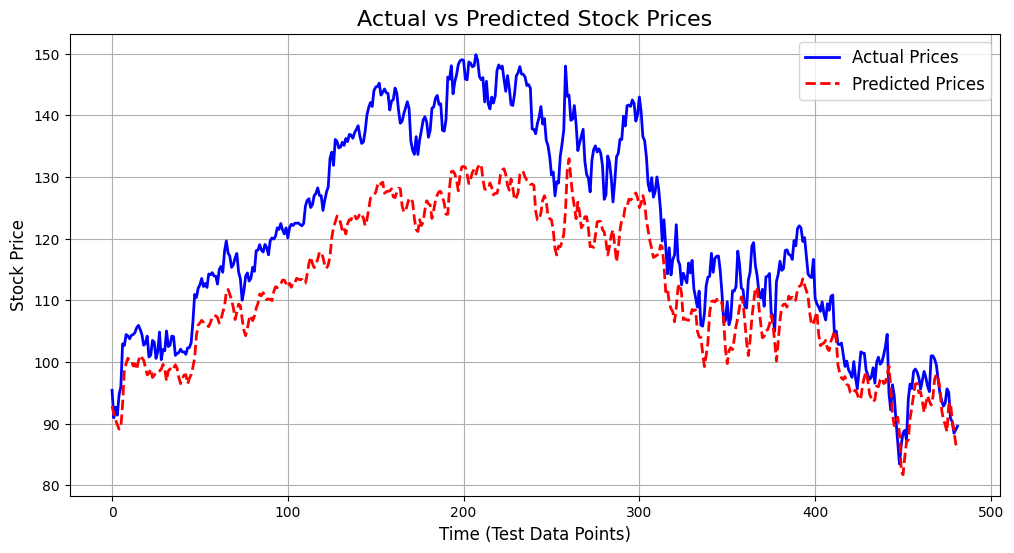

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 6))
plt.plot(Y_test_rescaled, label='Actual Prices', color='blue', linewidth=2)
plt.plot(Y_pred_rescaled, label='Predicted Prices', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Stock Prices', fontsize=16)
plt.xlabel('Time (Test Data Points)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Build LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#Train LSTM model

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history_lstm = lstm_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


lstm_model.save('lstm_model.h5')

print("LSTM model trained and saved successfully!")


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.7860e-04 - mae: 0.0111 - val_loss: 2.1562e-04 - val_mae: 0.0104
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.1750e-05 - mae: 0.0045 - val_loss: 2.5797e-04 - val_mae: 0.0118
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.0310e-05 - mae: 0.0050 - val_loss: 2.1851e-04 - val_mae: 0.0111
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.8446e-05 - mae: 0.0050 - val_loss: 2.2312e-04 - val_mae: 0.0109
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5.5054e-05 - mae: 0.0053 - val_loss: 1.9624e-04 - val_mae: 0.0104
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.1523e-05 - mae: 0.0040 - val_loss: 2.5712e-04 - val_mae: 0.0127
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.7033e-05 - mae: 0.0042 - val_loss: 1.7101e-04 - val_mae: 0.0093
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.8001e-05 - mae: 0.0037 - val_loss: 1.5418e-04 - val_mae: 0.0088


LSTM model trained and saved successfully!


# Training and Validation loss of LSTM model

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import joblib


np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test)


joblib.dump(scaler, 'scaler.pkl')

print("Test data and scaler saved for future testing.")


Test data and scaler saved for future testing.


# Predict the LSTM model based on test data

In [ ]:

Y_pred = lstm_model.predict(X_test)


Y_test_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y, 0] for y in Y_test]
)[:, 3]
Y_pred_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y[0], 0] for y in Y_pred]
)[:, 3]


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


# PKOt the graph

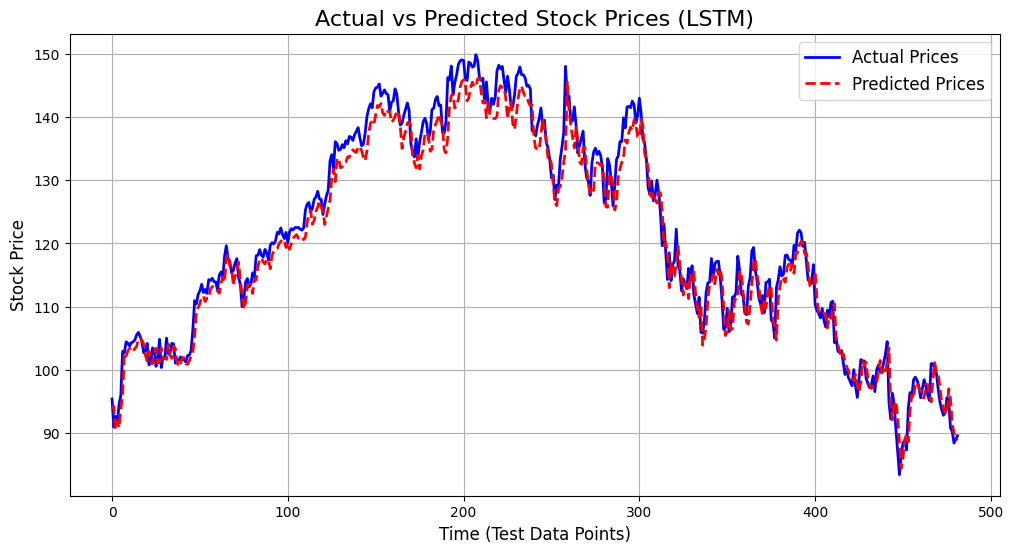

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(Y_test_rescaled, label='Actual Prices', color='blue', linewidth=2)
plt.plot(Y_pred_rescaled, label='Predicted Prices', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Stock Prices (LSTM)', fontsize=16)
plt.xlabel('Time (Test Data Points)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()


#Performance matrics calculation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


Y_pred = vanilla_rnn_model.predict(X_test)



mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)


rmse = np.sqrt(mse)


mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)


mpe = np.mean(((Y_test_rescaled - Y_pred_rescaled) / Y_test_rescaled) * 100)


r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)

# Print metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"R² Score: {r2}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 8.666420430277562
RMSE: 2.943878467307637
MAE: 2.34658056764678
MPE: 1.0637090871505506
R² Score: 0.9701192738902721


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


rmse = np.sqrt(mean_squared_error(Y_test_rescaled, Y_pred_rescaled))


mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)


mpe = np.mean((Y_test_rescaled - Y_pred_rescaled) / Y_test_rescaled) * 100


directional_accuracy = np.mean(
    np.sign(Y_test_rescaled[1:] - Y_test_rescaled[:-1]) == np.sign(Y_pred_rescaled[1:] - Y_test_rescaled[:-1])
) * 100


r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)

# Print metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"Directional Accuracy: {directional_accuracy}%")
print(f"R² Score: {r2}")


RMSE: 2.943878467307637
MAE: 2.34658056764678
MPE: 1.0637090871505506
Directional Accuracy: 48.232848232848234%
R² Score: 0.9701192738902721


# Build GRU model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the GRU model
gru_model = Sequential([
    GRU(50, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#Train the model

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history_gru = gru_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


gru_model.save('gru_model.h5')

print("GRU model trained and saved successfully!")


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1.4005e-04 - mae: 0.0085 - val_loss: 1.2886e-04 - val_mae: 0.0082
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 2.3659e-05 - mae: 0.0034 - val_loss: 1.3891e-04 - val_mae: 0.0088
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 2.2654e-05 - mae: 0.0034 - val_loss: 1.4505e-04 - val_mae: 0.0091
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 2.5097e-05 - mae: 0.0035 - val_loss: 1.6019e-04 - val_mae: 0.0098
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 2.4469e-05 - mae: 0.0035 - val_loss: 1.5144e-04 - val_mae: 0.0093
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 3.2914e-05 - mae: 0.0042 - val_loss: 1.0422e-04 - val_mae: 0.0073
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.1400e-05 - mae: 0.0033 - val_loss: 1.0506e-04 - val_mae: 0.0073
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2.0414e-05 - mae: 0.0032 - val_loss: 1.0471e-04 - val_mae: 0.0072


GRU model trained and saved successfully!


# Training and validation loss of gru model

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predict vs Actual trend

In [ ]:

Y_pred = gru_model.predict(X_test)


Y_test_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y, 0] for y in Y_test]
)[:, 3]
Y_pred_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y[0], 0] for y in Y_pred]
)[:, 3]


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


# Actual vs Predict on stock price plot

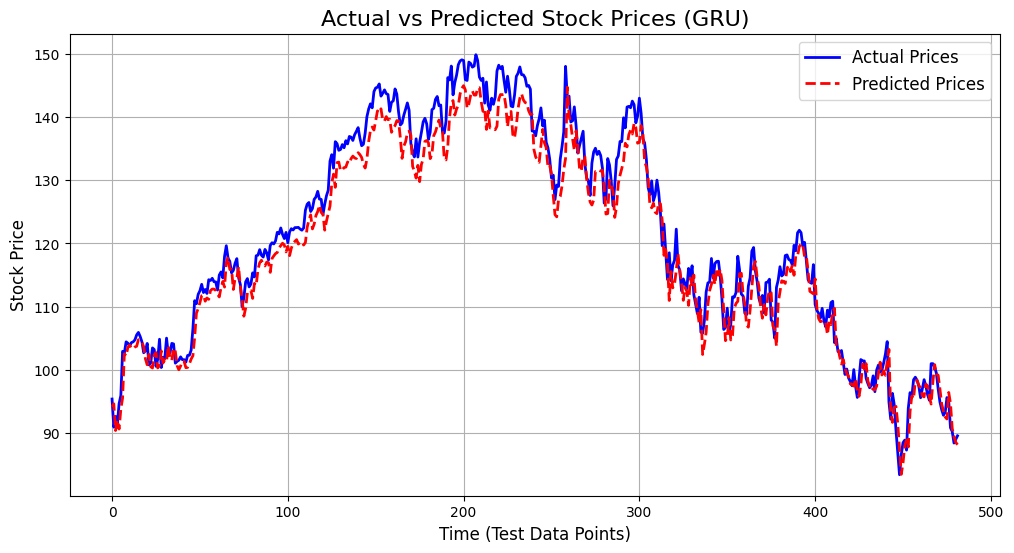

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(Y_test_rescaled, label='Actual Prices', color='blue', linewidth=2)
plt.plot(Y_pred_rescaled, label='Predicted Prices', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Stock Prices (GRU)', fontsize=16)
plt.xlabel('Time (Test Data Points)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()


#Performance matrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np




#  Mean Squared Error
mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Error
mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)

# Mean Percentage Error
mpe = np.mean(((Y_test_rescaled - Y_pred_rescaled) / Y_test_rescaled) * 100)

# Coefficient of Determination
r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)

# Print Metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"R² Score: {r2}")


MSE: 12.359930492156916
RMSE: 3.5156692808278933
MAE: 2.846948358748016
MPE: 1.7215466971208029
R² Score: 0.957384516393744


In [ ]:
# Predict on the validation data
Y_val_pred = gru_model.predict(X_val)

# Rescale predictions and actual values back to the original scale
Y_val_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y, 0] for y in Y_val]
)[:, 3]  # Extract only 'Close' column
Y_val_pred_rescaled = scaler.inverse_transform(
    [[0, 0, 0, y[0], 0] for y in Y_val_pred]
)[:, 3]  # Extract only 'Close' column


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


ACTual vs Predict based on validaton data

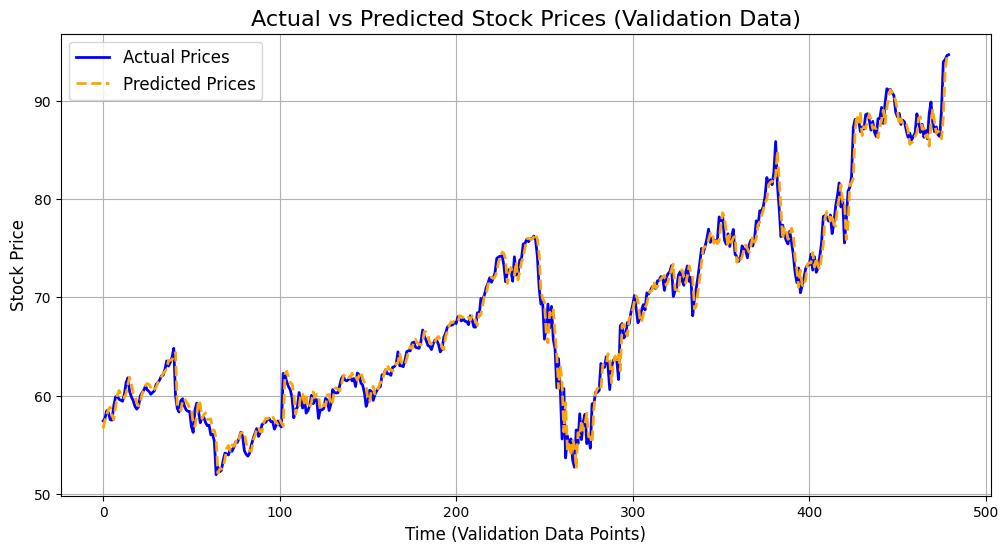

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(Y_val_rescaled, label='Actual Prices', color='blue', linewidth=2)
plt.plot(Y_val_pred_rescaled, label='Predicted Prices', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Stock Prices (Validation Data)', fontsize=16)
plt.xlabel('Time (Validation Data Points)', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()
